# ============ Part 1 ============

## ======= Load the libraries ===========

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as colors

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

Using TensorFlow backend.


## ========= ETL data =====

In [26]:
#read the data
df = pd.read_json('http://s3.amazonaws.com/istreet-assets/UNzfdIj426rLM2CsHhYbjA/MLand%20Stats%20Data%20Set.json')
#group the data points by 15 minutes
df.set_index('login_time', inplace = True)
df['count'] = 1
df_count = df.resample('15T', label = 'right', closed = 'left').sum()
#deal with the nan value in the data
df_count.fillna(0, inplace=True)
#transform the data into 2-d array (24*4 points for each day)
df_count.reset_index(inplace=True) #revert back to index range(23004)
#exclude the last day which is not complete for 24 hours.
df_2d = df_count.iloc[:22944, 1].values.reshape([-1, 24*4]) #easy to find using Spider GUI

## ====== Plot ======

### ========= Overall =========

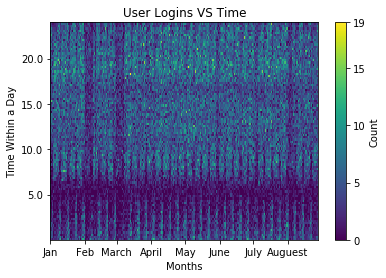

In [27]:
plt.pcolor(np.transpose(df_2d))
plt.colorbar(ticks = [0, 5, 10, 15, 19], label='Count') #19 is found to be the maximum
plt.xticks([0, 31, 59, 90, 120, 151, 181, 212], labels=['Jan', 'Feb', 'March', 'April', 'May', 'June', 'July', 'Auguest'])
plt.yticks([20, 40, 60, 80], labels = [str(i/4) for i in [20, 40, 60, 80]])
plt.xlabel('Months')
plt.ylabel('Time Within a Day')
plt.title('User Logins VS Time')
plt.show()

### ========== Each Month ========

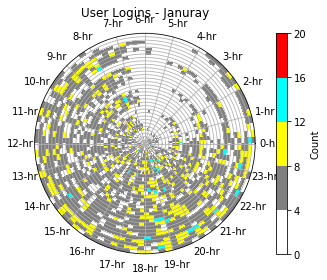

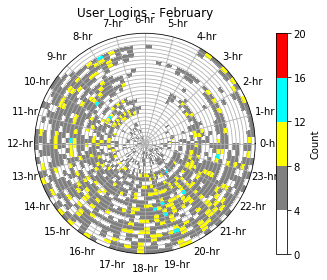

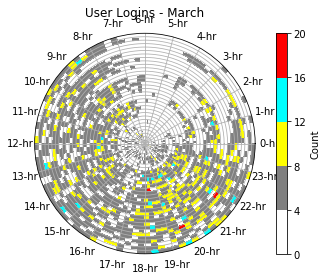

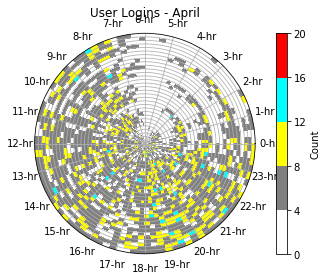

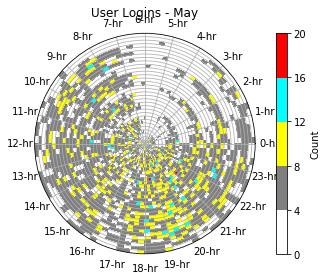

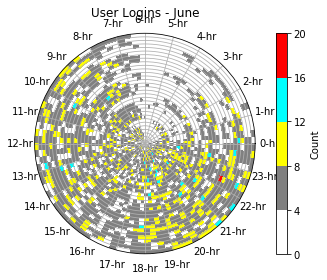

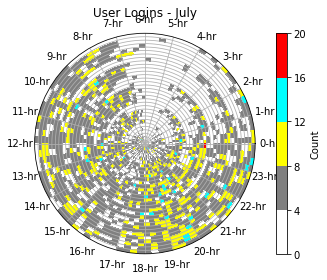

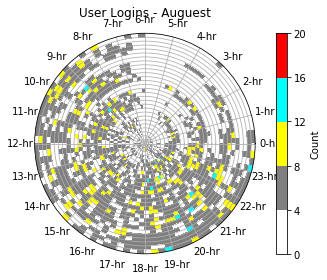

In [28]:
N = 24*4
bounds = np.array([0, 4, 8, 12, 16, 20])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=len(bounds)-1)
cmap = colors.ListedColormap(['white', 'grey', 'yellow', 'cyan', 'red'])

months = ['Januray', 'February', 'March', 'April', 'May', 'June', 'July', 'Auguest']
days = [31, 28, 31, 30, 31, 30, 31, 27]
month_days = dict(zip(months, days))
sum_days = 0
for month in months:
    days = month_days[month]
    rad = np.linspace(1, days+1, days+1)
    azm = np.linspace(0, 2 * np.pi, N+1, endpoint = True)
    r, th = np.meshgrid(rad, azm)

    plt.subplot(projection="polar")

    plt.pcolormesh(th, r, np.transpose(df_2d[sum_days:sum_days+days]), cmap = cmap, norm = norm)
    sum_days += days
    
    plt.title('User Logins - '+month)
    plt.thetagrids([theta * 15 for theta in range(360//15)], [str(i)+'-hr' for i in range(24)])
    plt.rgrids([ _ for _ in range(1, 1+days)], [])
    plt.grid()
    plt.colorbar(ticks = range(0, 21, 4),   label='Count').ax.set_yticklabels([str(i) for i in range(0, 21, 4)]) 
    plt.tight_layout()
    plt.show()

### ======== Tell the Data Story =======

In [29]:
print ('The following is what we can tell from the above graphs:\n'+
       '1. From January to Auguest the demand is generally small from midnight to 7:00 AM as\n '+
          'people are sleeping. However, during weekends (Saturdays and Sundays) people tend\n'+
           'to stay overnight, and won\'t sleep until 4:00 AM. Therefore, the demand is small during\n'+
           'from midnight to 7:00 AM on weekdays while large during midmight to around 4:00 AM at \nweekends.\n'+
       '2. The demand is on average during the day, however, from 6:00 PM when people are\n'+
       'off work to the time people go to sleep, there are periods of high demands. Therefore, '+
          'the demands after work are higher than average.\n' +
        '3. We may also notice that the demands are abnormal just during the first few days\n'+
           'of February and March, they are smaller than usual. The reason is unknown and needs\n'+
          ' to be investigated.\n'+
        '\n\nBsed upon the above a few conclusions, we need to adjust our supply decisions to meet\n'+
          'the demands as well as save the costs.\n')

The following is what we can tell from the above graphs:
1. From January to Auguest the demand is generally small from midnight to 7:00 AM as
 people are sleeping. However, during weekends (Saturdays and Sundays) people tend
to stay overnight, and won't sleep until 4:00 AM. Therefore, the demand is small during
from midnight to 7:00 AM on weekdays while large during midmight to around 4:00 AM at 
weekends.
2. The demand is on average during the day, however, from 6:00 PM when people are
off work to the time people go to sleep, there are periods of high demands. Therefore, the demands after work are higher than average.
3. We may also notice that the demands are abnormal just during the first few days
of February and March, they are smaller than usual. The reason is unknown and needs
 to be investigated.


Bsed upon the above a few conclusions, we need to adjust our supply decisions to meet
the demands as well as save the costs.



## ====== Forcast demands in an hour =======

### Use LSTM to do the modeling
### Use sliding window method to construct the data for LSTM 

In [38]:
data_lstm = df_count.iloc[:, 1:2].values
data_train = data_lstm[:-24*4*7]
data_test = data_lstm[-24*4*7:] #test the results for the last one week 
                         
#feature scaling
sc = MinMaxScaler(feature_range = (0, 1))
#sc = StandardScaler()

training_set_scaled = sc.fit_transform(data_train)
test_set_scaled = sc.transform(data_test) #only transform for test set data
#construct the data set for LSTM
def data_format(data, num_base):
    x = []
    y = []
    for i in range(num_base, data.shape[0]):
        x.append(data[i-num_base:i, 0])
        y.append(data[i, 0])
    x, y = np.array(x), np.array(y)
    x = x.reshape((x.shape[0], x.shape[1], 1))
    return x, y

num_base = 24*4*1 #number of points used as input (one day, week or more?)
x_train, y_train = data_format(training_set_scaled, num_base)
x_test, y_test = data_format(np.append(training_set_scaled[-num_base:], test_set_scaled, axis=0), num_base)

### Construct and Fit the LSTM

In [39]:
def build_regressor(_optimizer, x_train):
    #Initialise
    regressor = Sequential()
    
    #1st LSTM layer and some dropout regularization
    regressor.add(LSTM(units=50, return_sequences=True, input_shape = (x_train.shape[1], 1)))
    regressor.add(Dropout(0.2))
    
    #intermediate LSTM layers and dropout regularization
    for i in range(0): #more LSTM? too expensive in time.
        regressor.add(LSTM(units=50, return_sequences=True))
        regressor.add(Dropout(0.2))

    #last LSTM layer and dropout regularization
    regressor.add(LSTM(units=50))
    regressor.add(Dropout(0.2))
    
    #output layer
    regressor.add(Dense(units=1))
    
    #compile
    regressor.compile(optimizer=_optimizer, loss = 'mean_squared_error') 
    
    return regressor

regressor = build_regressor('rmsprop', x_train)

#fit the regressor
history = regressor.fit(x_train, y_train, epochs=10, batch_size=50, verbose=1, validation_data = (x_test, y_test))

Train on 22236 samples, validate on 672 samples
Epoch 1/10
22236/22236 [==============================] - 103s 5ms/step - loss: 0.0148 - val_loss: 0.0112
Epoch 2/10
22236/22236 [==============================] - 104s 5ms/step - loss: 0.0137 - val_loss: 0.0106
Epoch 3/10
22236/22236 [==============================] - 97s 4ms/step - loss: 0.0135 - val_loss: 0.0107
Epoch 4/10
22236/22236 [==============================] - 99s 4ms/step - loss: 0.0133 - val_loss: 0.0113
Epoch 5/10
22236/22236 [==============================] - 112s 5ms/step - loss: 0.0132 - val_loss: 0.0106
Epoch 6/10
22236/22236 [==============================] - 109s 5ms/step - loss: 0.0131 - val_loss: 0.0105
Epoch 7/10
22236/22236 [==============================] - 102s 5ms/step - loss: 0.0130 - val_loss: 0.0106
Epoch 8/10
22236/22236 [==============================] - 119s 5ms/step - loss: 0.0129 - val_loss: 0.0106
Epoch 9/10
22236/22236 [==============================] - 110s 5ms/step - loss: 0.0128 - val_loss: 0.0113


## Predict and Visualize

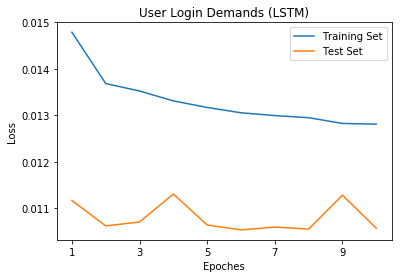

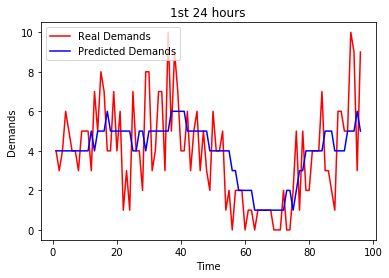

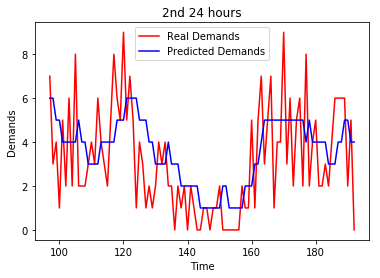

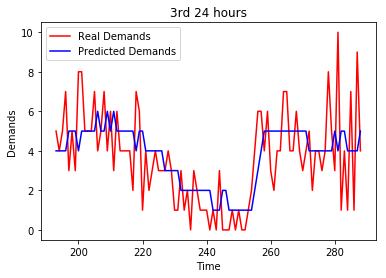

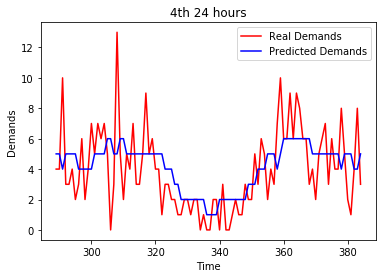

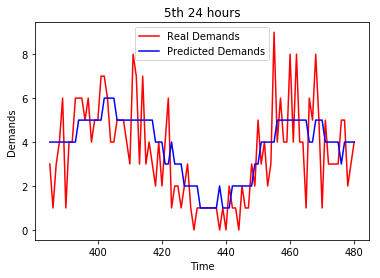

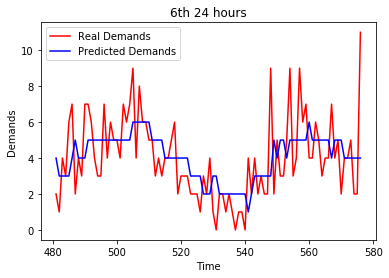

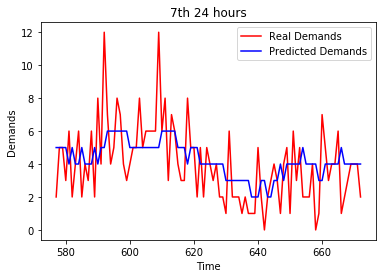

The predictions for the first 4 points in data_test are [4, 4, 4, 4] and the real values for them are [4. 3. 4. 6.]
====== Discussion =======
We used LSTM to predict the next demand based on the previous num_base demands. Through the above 7 plots of the predictions for 24*7 hours, we can see that the model generally predicts the trend of the demands but is not able to give  accurate values, especially at times when the demands are very high. This defect can be due to many reasons in the current model. For example, due to the long computation time in my Mac, I only considered the hyper parameters with small values, i.e. num_base, epoches, the LSTM nodes in each layer, etc., so to improve the model, we definitely need to try more hyperparameter options. All in all, this model is good and can catch the overall trend of the demands.
To predict the demands for a future hour, we first predict the demand for the frist future 15 minutes, which is used as a part of input data to predict the se

In [44]:
#predict
y_pred = regressor.predict(x_test)
y_pred = sc.inverse_transform(y_pred)
#round y_pred to the nearest integers
for i in range(y_pred.shape[0]):
    for j in range(y_pred.shape[1]):
        y_pred[i, j] = int(y_pred[i, j]+0.5)

#visualize
num_epoches = len(history.history['loss'])
plt.plot (history.history['loss'], label = 'Training Set')
plt.plot (history.history['val_loss'], label = 'Test Set')
plt.xticks(range(0, 9, 2), labels = [str(i+1)for i in range(0, 9, 2)])
plt.title('User Login Demands (LSTM)')
plt.ylabel('Loss')
plt.xlabel('Epoches')
plt.legend()
plt.show()
#predict
y_test_sc_reverse = sc.inverse_transform(y_test.reshape(-1, 1))
for i in range(7):
    plt.plot(range(1+24*4*i, 1+24*4*(i+1)), y_test_sc_reverse[24*4*i:24*4*(i+1)], color = 'red', label = 'Real Demands')
    plt.plot(range(1+24*4*i, 1+24*4*(i+1)), y_pred[24*4*i:24*4*(i+1)], color = 'blue', label = 'Predicted Demands')
    plt.title(['1st', '2nd', '3rd', '4th', '5th', '6th', '7th'][i]+' 24 hours')
    plt.xlabel('Time')
    plt.ylabel('Demands')
    plt.legend()
    plt.show()

#make predictions for a sequent 4 future time points
def predict_one_hr (data): #raw data, not scaled (data_train)
    #choose the last num_base of points as the initial input data
    pred = [] #un-scaled value
    data_input = list(data[-num_base:][:, 0]) #unscaled value
    
    for i in range(4):
        inpt = sc.transform(np.array(data_input[-(num_base-i):] +\
               pred).reshape((-1, 1))) #take the existing predictions as part of the input.
        inpt = inpt.reshape((inpt.shape[1], inpt.shape[0], 1))
        pred.append(sc.inverse_transform(regressor.predict(inpt)).item()) #extract the value
    return pred

pred_hr = predict_one_hr(data_train)
for i in range(len(pred_hr)):
    pred_hr[i] = int(pred_hr[i]+0.5)
print ('The predictions for the first 4 points in data_test are', pred_hr, 'and the real values for them are', data_test[:4, 0])

print ('====== Discussion =======\nWe used LSTM to predict the next demand based on the previous num_base demands. Through the above 7 plots of the predictions for 24*7 hours, we can see that the model generally predicts the trend of the demands but is not able to give  accurate values, especially at times when the demands are very high. This defect can be due to many reasons in the current model. For example, due to the long computation time in my Mac, I only considered the hyper parameters with small values, i.e. num_base, epoches, the LSTM nodes in each layer, etc., so to improve the model, we definitely need to try more hyperparameter options. All in all, this model is good and can catch the overall trend of the demands.\nTo predict the demands for a future hour, we first predict the demand for the frist future 15 minutes, which is used as a part of input data to predict the second future 15 minutes. So in this way, we get the predictions for the future hour. We used this method to predict the demands for the first hour in the test data set, and the predictions are not bad at all.')